# M4-forecasting

## Libraries

In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import mxnet as mx
from mxnet import gluon
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx import (
    Trainer,
    SimpleFeedForwardEstimator,
    NBEATSEstimator, 
    NBEATSEnsembleEstimator,
    TemporalFusionTransformerEstimator,
    DeepAREstimator,
)
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.evaluation import make_evaluation_predictions

from pathlib import Path
from zipfile import ZipFile
import json

plt.rcParams["figure.figsize"] = (14, 4)
pd.options.display.max_columns = 99

## Parameters

In [2]:
root = "/home/ec2-user/projects/m4-forecasting"
unzip = False
session = "test"
dataset = "Monthly"
horizon = 18

## Constants

In [3]:
freq_alias = {
    "Yearly": "Y",
    "Quarterly": "Q",
    "Monthly": "M",
    "Weekly": "W",
    "Daily": "D",
    "Hourly": "H",
}

## Utils

## Set directories

In [4]:
root = Path(root)
data_dir = root / "data"
session_dir = data_dir / f"session/{session}"

data_dir.mkdir(exist_ok=True)
session_dir.mkdir(exist_ok=True, parents=True)

## Load

In [5]:
if unzip:
    with ZipFile(data_dir / "m4-forecasting.zip", 'r') as f:
        f.extractall(data_dir / "raw")

In [6]:
train_orig_df = pd.read_csv(data_dir / f"raw/{dataset}-train.csv")

In [7]:
m4_info = pd.read_csv(data_dir / f"raw/m4_info.csv")

In [8]:
train_orig_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,...,V2747,V2748,V2749,V2750,V2751,V2752,V2753,V2754,V2755,V2756,V2757,V2758,V2759,V2760,V2761,V2762,V2763,V2764,V2765,V2766,V2767,V2768,V2769,V2770,V2771,V2772,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,5260.0,5470.0,7870.0,7360.0,8470.0,7880.0,6750.0,6860.0,6220.0,6650.0,5450.0,5280.0,4970.0,5550.0,7750.0,7760.0,7190.0,7440.0,6590.0,6210.0,6010.0,6390.0,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,6250.0,6900.0,5870.0,5610.0,6310.0,6110.0,6090.0,5810.0,6060.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,2150.0,1910.0,2510.0,2100.0,1840.0,2330.0,1830.0,2290.0,2090.0,2340.0,2420.0,1850.0,1960.0,2000.0,2300.0,2160.0,1730.0,2090.0,1890.0,2180.0,1950.0,2020.0,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,1730.0,1860.0,1880.0,2120.0,2140.0,2090.0,1890.0,1840.0,2130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,2796.0,2858.0,2782.0,2801.0,2907.0,2919.0,2937.0,2878.0,2841.0,2967.0,3050.0,2981.0,3076.0,3033.0,2936.0,2927.0,2929.0,2987.0,2777.0,2760.0,2769.0,2830.0,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,3060.0,3008.0,2972.0,2955.0,3350.0,3445.0,3432.0,3447.0,3450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,7067.0,7099.0,7046.0,7139.0,7011.0,7022.0,7084.0,7036.0,7098.0,7083.0,7045.0,7057.0,6986.0,6937.0,6927.0,6953.0,7007.0,6949.0,6930.0,6925.0,6956.0,6946.0,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,6898.0,6922.0,6768.0,6693.0,6656.0,6567.0,6663.0,6652.0,6714.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,4180.0,4230.0,4270.0,4500.0,4410.0,4440.0,4430.0,4440.0,4540.0,4450.0,4420.0,4410.0,4300.0,4300.0,4420.0,4350.0,4340.0,4410.0,4340.0,4400.0,4360.0,4420.0,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,4190.0,4180.0,4320.0,4190.0,4200.0,4320.0,4220.0,4290.0,4230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,M47996,9964.0,7212.0,7858.0,8493.0,8203.0,8362.0,7238.0,7357.0,8642.0,8833.0,11009.0,12475.0,10416.0,7056.0,8365.0,9004.0,9888.0,9469.0,7868.0,7774.0,9062.0,9342.0,10767.0,11281.0,9052.0,7993.0,8742.0,8650.0,8478.0,8154.0,6827.0,6313.0,7228.0,8280.0,9580.0,10622.0,9985.0,6370.0,7657.0,7889.0,7587.0,7375.0,6440.0,6065.0,7631.0,7781.0,9235.0,11249.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
m4_info

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


## Prepare

In [10]:
def remove_trailing_nan(df):
    df = df.set_index("t")
    df = df.loc[:df.y.last_valid_index()].reset_index()
    return df

In [11]:
def parse_dates(m4_info):
    dates = []

    match = m4_info.StartingDate.str.fullmatch(r"\d\d-\d\d-\d\d \d\d:\d\d")
    dates.append(pd.to_datetime(m4_info.loc[match, "StartingDate"], format="%d-%m-%y %H:%M"))

    match = m4_info.StartingDate.str.fullmatch(r"\d\d-\d\d-\d\d \d:\d\d")
    dates.append(pd.to_datetime(m4_info.loc[match, "StartingDate"], format="%d-%m-%y %H:%M"))

    match = m4_info.StartingDate.str.fullmatch(r"\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d")
    dates.append(pd.to_datetime(m4_info.loc[match, "StartingDate"], format="%Y-%m-%d %H:%M:%S"))

    dates = pd.concat(dates)
    dates[dates.dt.year > 2018] = dates[dates.dt.year > 2018] - pd.offsets.DateOffset(years=100)

    m4_info = m4_info.copy()
    m4_info["StartingDate"] = dates

    return m4_info

In [16]:
def add_date_col(df):
    df = df.copy()
    freq = df["SP"].iloc[0]

    start = df["StartingDate"].iloc[0]
    periods = len(df)
    try:
        dates = pd.date_range(start=start, periods=periods, freq=freq_alias[freq], normalize=True)
    except pd.errors.OutOfBoundsDatetime:
        dates = pd.DatetimeIndex([pd.NaT for _ in range(periods)])
    df["date"] = dates
    return df

In [17]:
def prepare_data(df, m4_info):
    m4_info = parse_dates(m4_info)
    df.columns = pd.Index(["unique_id"] + list(range(df.shape[1] - 1)))
    df = pd.melt(df, id_vars=["unique_id"], value_name="y", var_name="t")
    df["t"] = pd.to_numeric(df["t"])
    df = df.groupby("unique_id").apply(remove_trailing_nan).reset_index(drop=True)
    df = df.merge(m4_info, left_on="unique_id", right_on="M4id")
    df = df.groupby("unique_id", group_keys=False).apply(add_date_col)
    df = df[["unique_id", "date", "t", "y", "category"]]
    return df

In [18]:
train_df = prepare_data(train_orig_df, m4_info)

In [19]:
train_df.isna().sum()

unique_id    0
date         0
t            0
y            0
category     0
dtype: int64

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10382411 entries, 0 to 10382410
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   unique_id  object        
 1   date       datetime64[ns]
 2   t          int64         
 3   y          float64       
 4   category   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 475.3+ MB


In [21]:
filepath = session_dir / "train_df.csv"
train_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

Data written to /home/ec2-user/projects/m4-forecasting/data/session/test/train_df.csv


In [22]:
val_df = train_df.groupby("unique_id", group_keys=False).apply(lambda x: x.tail(18))

In [23]:
val_df

,unique_id,date,t,y,category
451,M1,2014-01-31,451,7250.0,Macro
452,M1,2014-02-28,452,6830.0,Macro
453,M1,2014-03-31,453,6810.0,Macro
454,M1,2014-04-30,454,5810.0,Macro
455,M1,2014-05-31,455,6220.0,Macro
...,...,...,...,...,...
10382406,M9999,2015-05-31,64,5600.0,Macro
10382407,M9999,2015-06-30,65,4500.0,Macro
10382408,M9999,2015-07-31,66,5100.0,Macro
10382409,M9999,2015-08-31,67,4800.0,Macro


In [24]:
val_df.groupby("unique_id").size().unique()

array([18])

In [25]:
filepath = session_dir / "val_df.csv"
val_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

Data written to /home/ec2-user/projects/m4-forecasting/data/session/test/val_df.csv


## Model

In [505]:
train_full_df = pd.read_csv(session_dir / "train_df.csv", parse_dates=["date"])

In [633]:
df = train_full_df.copy()

In [634]:
df = df[df.unique_id.isin(df.unique_id.sample(1000))].copy()

In [635]:
df["y_scaled"] = df.groupby("unique_id", group_keys=False)["y"].apply(lambda x: (x - x.mean()) / x.std())
df["month"] = df.date.dt.month

In [637]:
df["unique_id"] = pd.factorize(df["unique_id"])[0]
df["t"] = df["t"].astype("float32")
df["category"] = pd.factorize(df["category"])[0]
df = pd.get_dummies(df, columns=["month"])

In [639]:
df

,unique_id,date,t,y,category,y_scaled,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
20903,0,1973-01-31,0.0,1057.53,0,0.067174,1,0,0,0,0,0,0,0,0,0,0,0
20904,0,1973-02-28,1.0,1017.83,0,-0.274713,0,1,0,0,0,0,0,0,0,0,0,0
20905,0,1973-03-31,2.0,1000.00,0,-0.428261,0,0,1,0,0,0,0,0,0,0,0,0
20906,0,1973-04-30,3.0,994.53,0,-0.475367,0,0,0,1,0,0,0,0,0,0,0,0
20907,0,1973-05-31,4.0,984.52,0,-0.561571,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10362194,979,2014-12-31,239.0,2386.80,1,1.009650,0,0,0,0,0,0,0,0,0,0,0,1
10362195,979,2015-01-31,240.0,2401.40,1,1.031011,1,0,0,0,0,0,0,0,0,0,0,0
10362196,979,2015-02-28,241.0,2421.60,1,1.060565,0,1,0,0,0,0,0,0,0,0,0,0
10362197,979,2015-03-31,242.0,2443.10,1,1.092022,0,0,1,0,0,0,0,0,0,0,0,0


In [640]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297143 entries, 20903 to 10362198
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   unique_id  297143 non-null  int64         
 1   date       297143 non-null  datetime64[ns]
 2   t          297143 non-null  float32       
 3   y          297143 non-null  float64       
 4   category   297143 non-null  int64         
 5   y_scaled   297143 non-null  float64       
 6   month_1    297143 non-null  uint8         
 7   month_2    297143 non-null  uint8         
 8   month_3    297143 non-null  uint8         
 9   month_4    297143 non-null  uint8         
 10  month_5    297143 non-null  uint8         
 11  month_6    297143 non-null  uint8         
 12  month_7    297143 non-null  uint8         
 13  month_8    297143 non-null  uint8         
 14  month_9    297143 non-null  uint8         
 15  month_10   297143 non-null  uint8         
 16  month_11   297

<AxesSubplot: >

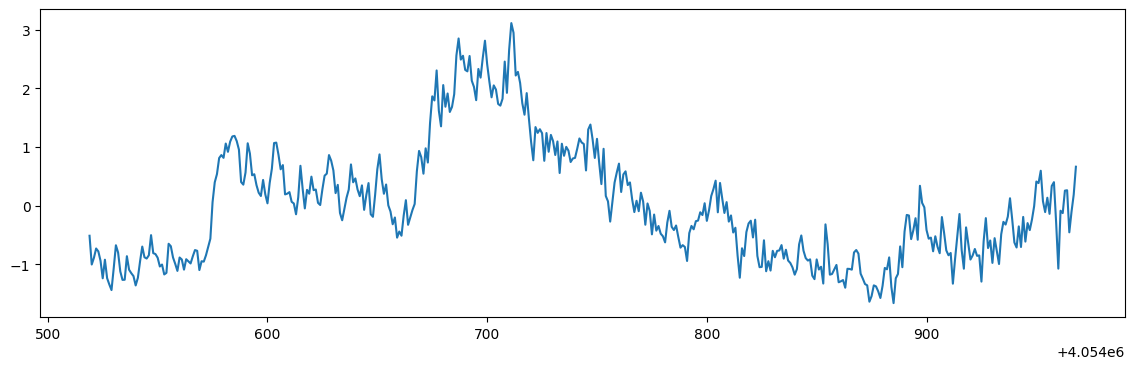

In [641]:
df.loc[df.unique_id == df.unique_id.sample(1).iloc[0], "y_scaled"].plot()

In [642]:
train_df = df.groupby("unique_id", group_keys=False).apply(lambda x: x.iloc[:-horizon])
val_df = df.copy()

### Build datasets

In [647]:
dataset_train = PandasDataset.from_long_dataframe(
    train_df, 
    target="y_scaled",
    timestamp="date",
    item_id="unique_id",
    freq="M",
    feat_dynamic_real=["t"],
    feat_dynamic_cat=[
        "month_1", 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
    ],
    feat_static_cat=["unique_id", "category"],
)

In [648]:
dataset_val = PandasDataset.from_long_dataframe(
    val_df, 
    target="y_scaled",
    timestamp="date",
    item_id="unique_id",
    freq="M",
    feat_dynamic_real=["t"],
    feat_dynamic_cat=[
        "month_1", 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
    ],
    feat_static_cat=["unique_id", "category"],
)

In [600]:
elem_train_it = iter(dataset_train)
elem_val_it = iter(dataset_val)

<AxesSubplot: >

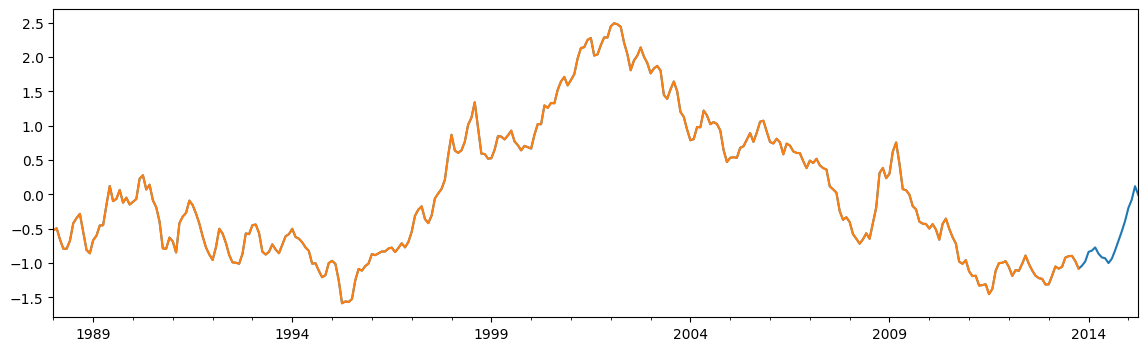

In [601]:
to_pandas(next(elem_val_it)).plot()
to_pandas(next(elem_train_it)).plot()

## Temporal Fusion Transformer

In [654]:
estimator_tft = TemporalFusionTransformerEstimator(
    trainer=Trainer(
        ctx=mx.gpu(), 
        epochs=100, 
        learning_rate=1e-3, 
        num_batches_per_epoch=50,
    ),
    freq=freq_alias[dataset], 
    prediction_length=horizon,
    context_length=3*horizon,
    hidden_dim=32,
)

In [655]:
predictor_tft = estimator_tft.train(dataset_train)

 28%|██▊       | 14/50 [00:01<00:03, 10.18it/s, epoch=30/100, avg_epoch_loss=0.0765]
/home/ec2-user/anaconda3/envs/gluonts/lib/python3.11/site-packages/gluonts/mx/trainer/_base.py:474: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(


In [558]:
predictor_tft.serialize(session_dir)

In [604]:
train_it = iter(dataset_train)
fcst_it, val_it = make_evaluation_predictions(
    dataset=dataset_val,
    predictor=predictor_tft,
    num_samples=100,
)

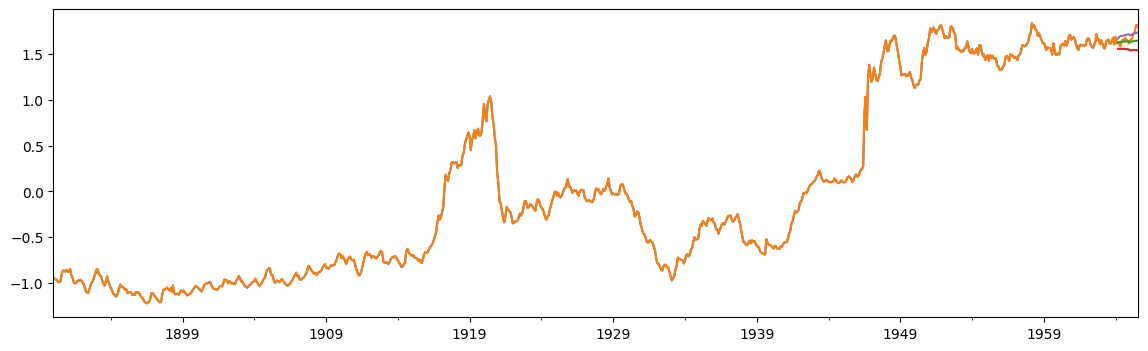

In [619]:
y_train = to_pandas(next(train_it))
y_val = next(val_it)[0]
y_fcst = next(fcst_it)

y_train.plot()
y_val.plot()
y_fcst.plot()

## DeepAR

In [649]:
dataset_train = PandasDataset.from_long_dataframe(
    train_df, 
    target="y_scaled",
    timestamp="date",
    item_id="unique_id",
    freq="M",
    feat_dynamic_real=[
        "t", "month_1", 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
    ],
    feat_static_cat=["unique_id", "category"],
)

In [650]:
dataset_val = PandasDataset.from_long_dataframe(
    val_df, 
    target="y_scaled",
    timestamp="date",
    item_id="unique_id",
    freq="M",
    feat_dynamic_real=[
        "t", "month_1", 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
    ],
    feat_static_cat=["unique_id", "category"],
)

In [664]:
train_df.category.unique()

array([0, 1, 2, 3, 4, 5])

In [662]:
len(train_df.unique_id.unique())

980

In [665]:
estimator_deepar = DeepAREstimator(
    trainer=Trainer(
        ctx=mx.gpu(), 
        epochs=100, 
        learning_rate=1e-3, 
        num_batches_per_epoch=50,
    ),
    freq=freq_alias[dataset], 
    prediction_length=horizon,
    context_length=3*horizon,
    use_feat_dynamic_real=True,
    use_feat_static_real=False,
    use_feat_static_cat=True,
    cardinality=[980, 6]
)

In [666]:
predictor_deepar = estimator_deepar.train(dataset_train)

100%|██████████| 50/50 [00:05<00:00,  9.68it/s, epoch=100/100, avg_epoch_loss=-.768]


In [667]:
predictor_deepar.serialize(session_dir)

In [668]:
train_it = iter(dataset_train)
fcst_it, val_it = make_evaluation_predictions(
    dataset=dataset_val,
    predictor=predictor_deepar,
    num_samples=100,
)

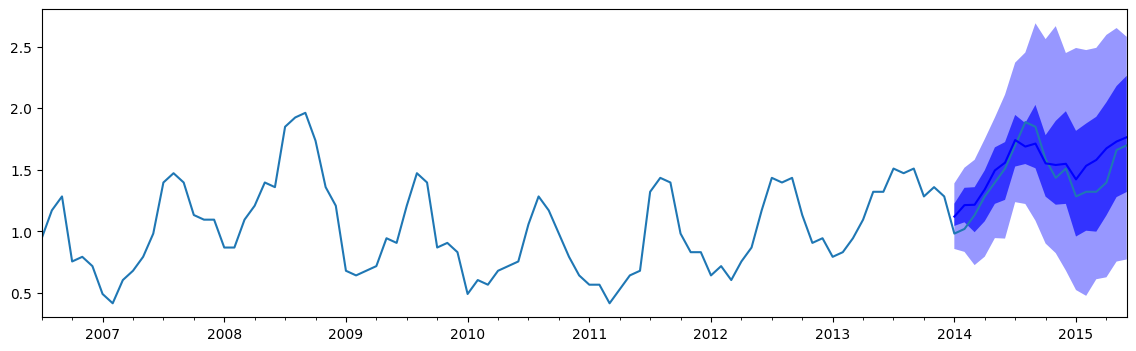

In [691]:
y_val = next(val_it)[0]
y_fcst = next(fcst_it)

y_val.tail(6*horizon).plot()
y_fcst.plot()

### NBEATS

In [244]:
estimator_nbeats = NBEATSEstimator(
    freq=freq_alias[dataset], 
    prediction_length=horizon,
    context_length=2*horizon,
    trainer=Trainer(
        ctx=mx.gpu(), 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100,
    ),
    num_stacks=2,
    widths=[256, 2048],
    num_blocks=[3],
    num_block_layers=[4],
    sharing=[True],
    expansion_coefficient_lengths=[3],
    stack_types=["T", "S"],
    loss_function="MAPE",
    batch_size=1024,
)

In [245]:
predictor_nbeats = estimator_nbeats.train(dataset_train)

100%|██████████| 100/100 [00:46<00:00,  2.15it/s, epoch=10/10, avg_epoch_loss=2.91e+7]


In [37]:
predictor_nbeats.serialize(session_dir)

In [ ]:
# predictor = Predictor.deserialize(session_dir)

In [246]:
train_it = iter(dataset_train)
fcst_it, val_it = make_evaluation_predictions(
    dataset=dataset_val,
    predictor=predictor_nbeats,
    num_samples=1,
)

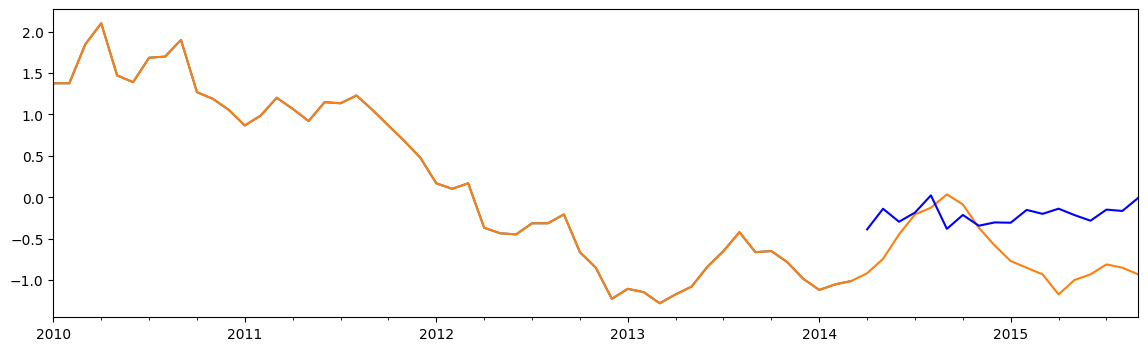

In [262]:
y_train = to_pandas(next(train_it))
y_val = next(val_it)[0]
y_fcst = next(fcst_it)

y_train.plot()
y_val.plot()
y_fcst.plot()

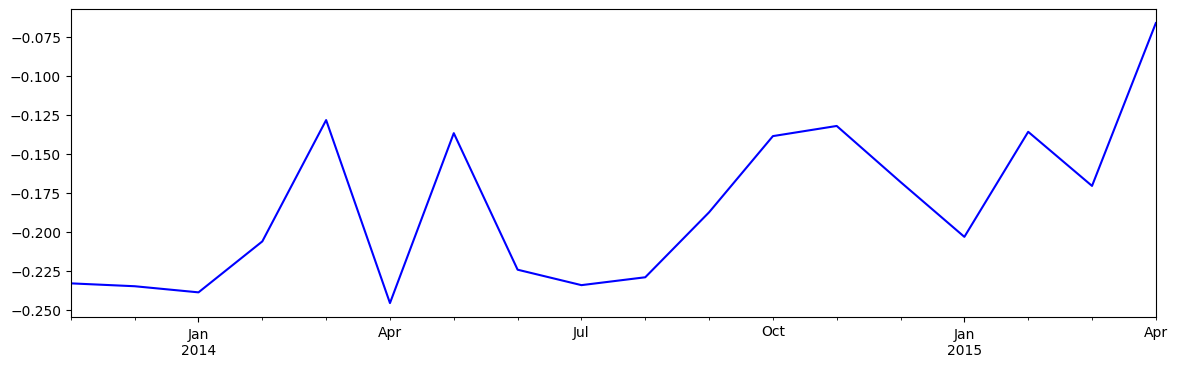

In [295]:
y_fcst = next(fcst_it)
y_fcst.plot()

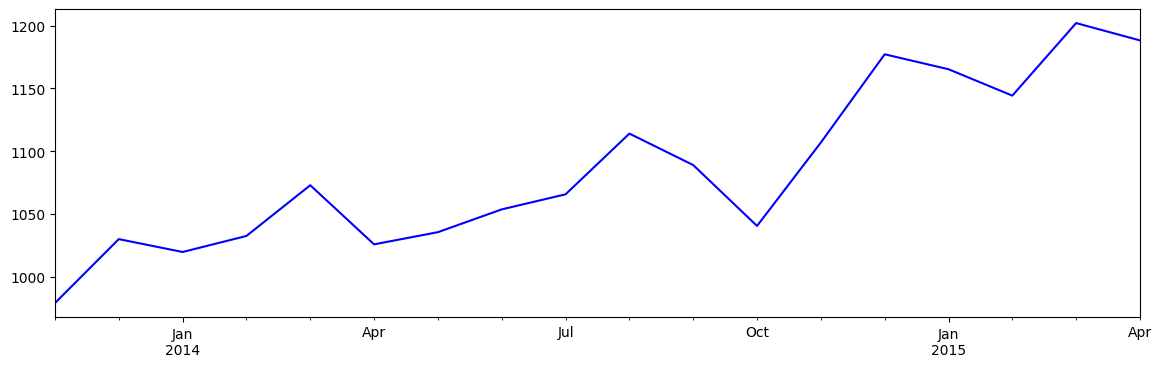

In [136]:
y_fcst = next(fcst_it)
y_fcst.plot()

In [111]:
y_fcst

gluonts.model.forecast.SampleForecast(info=None, item_id="M10001", samples=numpy.array([[978.8731689453125, 1029.8421630859375, 1019.5772094726562, 1032.3592529296875, 1072.777099609375, 1025.678466796875, 1035.3741455078125, 1053.544921875, 1065.54296875, 1113.9326171875, 1088.86865234375, 1040.356689453125, 1106.81201171875, 1177.1373291015625, 1165.2138671875, 1144.194580078125, 1202.0035400390625, 1188.192138671875]], numpy.dtype("float32")), start_date=pandas.Timestamp("2014-04", freq="M"))

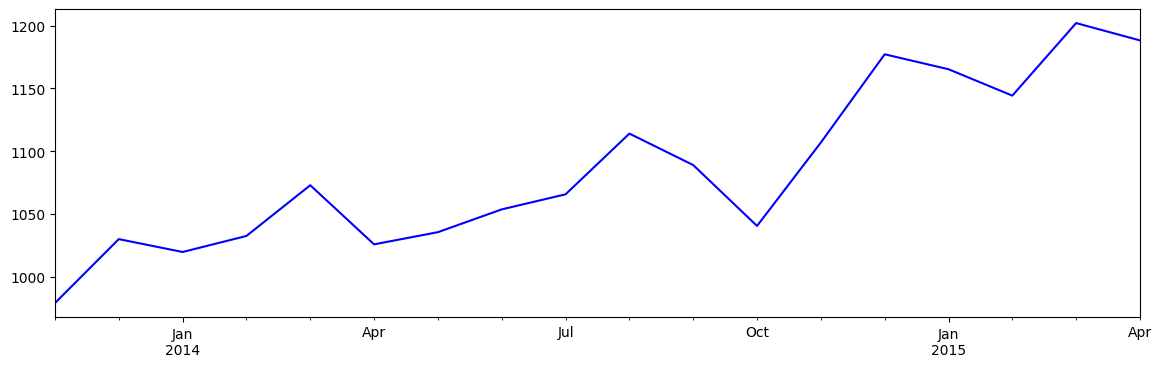

In [132]:
y_fcst = next(fcst_it)
y_fcst.plot()